runs/detect/result/crops/0/Enter--2024-11-25_17-15-53.jpg
253 1056 1


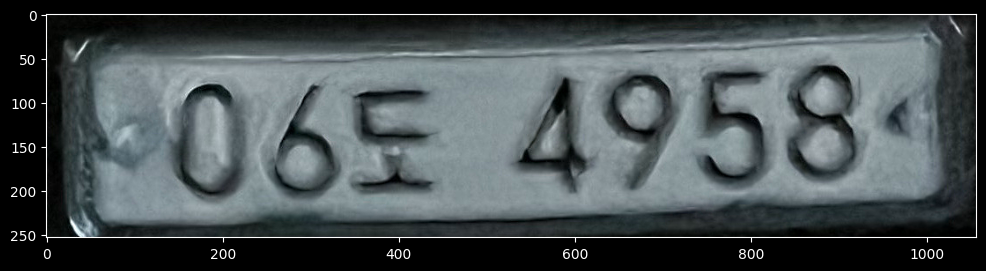

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
plt.style.use('dark_background')
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'


"""
- 특정 folder 내에 있는 "가장 최근에 생성된" 파일을 리턴하는 방법 
"""
folder_path = 'runs/detect/result/crops/0/'

# each_file_path_and_gen_time: 각 file의 경로와, 생성 시간을 저장함
each_file_path_and_gen_time = []
for each_file_name in os.listdir(folder_path):
    # getctime: 입력받은 경로에 대한 생성 시간을 리턴
    each_file_path = folder_path + each_file_name
    each_file_gen_time = os.path.getctime(each_file_path)
    each_file_path_and_gen_time.append(
        (each_file_path, each_file_gen_time)
    )

# 가장 생성시각이 큰(가장 최근인) 파일을 리턴 
most_recent_file = max(each_file_path_and_gen_time, key=lambda x: x[1])[0]
print(most_recent_file)
img_ori = cv2.imread(most_recent_file)      ##most_recent_file

height, width, channel = img_ori.shape
channel = 1

# Morphology Operation
StructuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
topHat = cv2.morphologyEx(img_ori, cv2.MORPH_TOPHAT, StructuringElement)
blackHat = cv2.morphologyEx(img_ori, cv2.MORPH_BLACKHAT, StructuringElement)
img_topHat = cv2.add(img_ori, topHat)
img_ori = cv2.subtract(img_topHat, blackHat)
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)
# Gaussian Blurring
blur = cv2.GaussianBlur(gray, (5, 5), 2)

# Adaptive Thresholding
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_blur_thresh = cv2.adaptiveThreshold(
img_blurred,
maxValue=255.0,
adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
thresholdType=cv2.THRESH_BINARY_INV,
blockSize=19,
C=9
)
plt.figure(figsize=(12, 10))
plt.imshow(img_ori,cmap='gray')
print(height, width, channel)


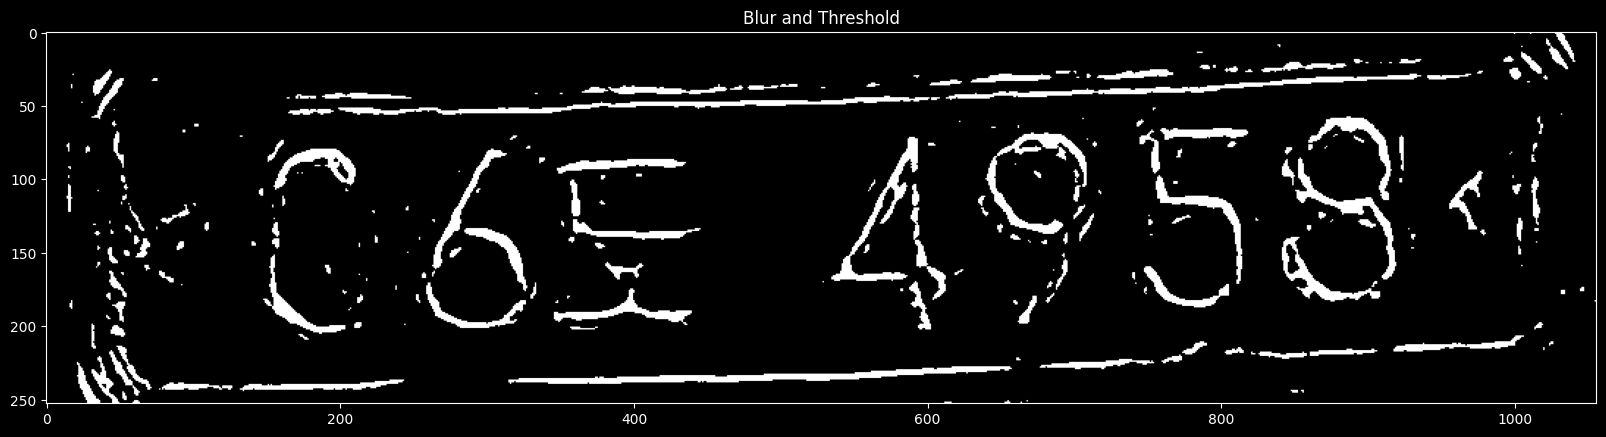

In [9]:
plt.figure(figsize=(20,20))
plt.title('Blur and Threshold')
plt.imshow(img_blur_thresh, cmap='gray')

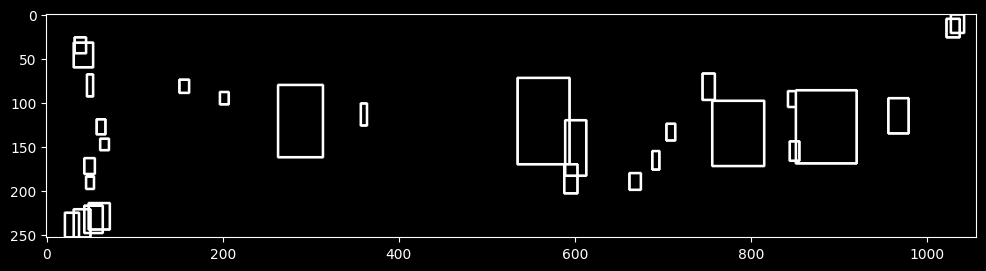

In [10]:
 # Find and Drawing Contours
contours, _ = cv2.findContours(img_blur_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contour_result = np.zeros((height, width, channel), dtype=np.uint8)
cv2.drawContours(contour_result, contours, -1, (255, 255, 255))
contour_result = np.zeros((height, width, channel), dtype=np.uint8)

# Drawing Rectangle with Contours
cntDict = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(contour_result, (x, y), (x + w, y + h), (255, 255, 255), 2)
    cntDict.append({'contour': contour, 'x': x, 'y': y, 'w': w, 'h': h, 'cx': x + (w / 2), 'cy': y + (h /
    2)})

# Plate Size Assumption
MINAREA = 100       # Minimum Area
MINWIDTH = 4        # Minimum Width
MINHEIGHT = 2       # Minimum Height
MINRATIO = 0.25     # Minimum Ratio (Width / Height)
MAXRATIO = 0.9      # Maximum Ratio (Width / Height)
    
# Candidates of the Plate
cntPossible = []
cnt = 0
for item in cntDict:
    # Calculate Conditions
    area = item['w'] * item['h'] # 가로 * 세로 넓이
    ratio = item['w'] / item['h'] # 가로 / 세로 비율
    
    # Check Conditions
    if area > MINAREA and item['w'] > MINWIDTH and item['h'] > MINHEIGHT and MINRATIO < ratio < MAXRATIO:
        item['index'] = cnt
        cnt += 1
        cntPossible.append(item)
        
contour_result = np.zeros((height, width, channel), dtype=np.uint8)

# Draw Rectangle on Candidates
for cnt in cntPossible:
	cv2.rectangle(contour_result, (cnt['x'], cnt['y']), (cnt['x'] + cnt['w'], cnt['y'] + cnt['h']), (255, 255,
255), 2)

contours_dict = []
    
plt.figure(figsize=(12,10))
plt.imshow(contour_result, cmap='gray')
    

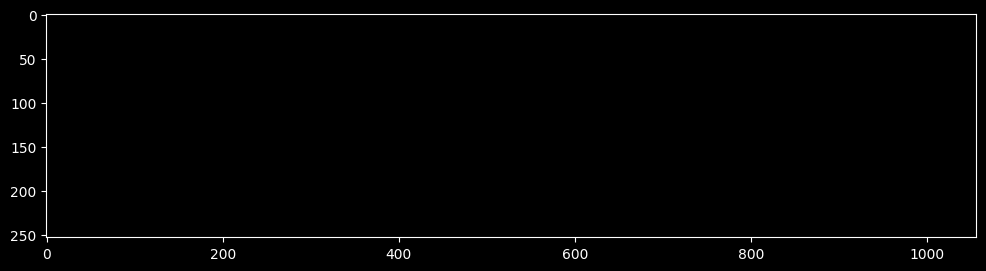

In [11]:
# Numeral Arrange Appearance Conditions
MAXDIAG = 5             # Average Distance from Center
MAXANGLE = 12           # Maximum Angle between Contours
MAXAREADIFF = 0.5       # Maximum Area Difference between Contours
MAXWIDTHDIFF = 0.8      # Maximum Width Difference between Contours
MAXHEIGHTDIFF = 0.2     # Maximum Height Difference between Contours
MINCHARACTER = 5        # Minimum Counts of Numbers

# Recursive Function to Find Characters
def FindCharacter(cntList):
    result = []

    for item1 in cntList:
        match = []
        for item2 in cntList:
            # Same Index Contours are not be compared
            if item1['index'] == item2['index']:
                continue

            # Distance from Center Point
            dx = abs(item1['cx'] - item2['cx'])
            dy = abs(item1['cy'] - item2['cy'])

            # First Contour's Diagonal Length
            diagLength = np.sqrt(item1['w'] ** 2 + item1['h'] ** 2)

            # Distance between Vectors
            distance = np.linalg.norm(np.array([item1['cx'], item1['cy']]) - np.array([item2['cx'], item2['cy']]))

            # Angle Calculations
            if dx == 0:
                angle = 90
            else:
                angle = np.degrees(np.arctan(dy / dx))
                
            DiffArea = abs(item1['w'] * item1['h'] - item2['w'] * item2['h']) / (item1['w'] * item1['h'])
            DiffWidth = abs(item1['w'] - item2['w']) / item1['w']
            DiffHeight = abs(item1['h'] - item2['h']) / item1['h']

            # Check Conditions
            if distance < diagLength * MAXDIAG and angle < MAXANGLE and DiffArea < MAXAREADIFF and DiffWidth < MAXWIDTHDIFF and DiffHeight < MAXHEIGHTDIFF:
                match.append(item2['index'])
            
        match.append(item1['index'])

        if len(match) < MINCHARACTER:
            continue

        result.append(match)

        # Unmatched Contours
        unmatch = []
        for item3 in cntList:
            if item3['index'] not in match:
                unmatch.append(item3['index'])

        # Only Take Same Contours
        unmatch = np.take(cntPossible, unmatch)

        # Function Called Recursively
        recursion = FindCharacter(unmatch)

        for i in recursion:
            result.append(i)

        break

    return result

# Index of Character Contours
indexResult = FindCharacter(cntPossible)

matchResult = []
for indexList in indexResult:
    matchResult.append(np.take(cntPossible, indexList))

# Visualize Possible Contours
possibleResult = np.zeros((height, width, channel), dtype=np.uint8)
    
for items in matchResult:
    for item in items:
        cv2.rectangle(possibleResult, (item['x'], item['y']), (item['x'] + item['w'], item['y'] + item['h']), (255, 255, 255), 2)
    
# Get Number Plate Informations
for i, items in enumerate(matchResult):
    # Sortion to Axis X
    sortion = sorted(items, key=lambda x: x['cx'])

plt.figure(figsize=(12, 10))
plt.imshow(possibleResult, cmap='gray')

In [12]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT=2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matchResult):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(img_blur_thresh, M=rotation_matrix, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matchResult), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

In [13]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    
    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 3')
    
    result_chars = ''
    has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            if c.isdigit():
                has_digit = True
            result_chars += c
    
    print(result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')